# Comparison between GPlearn SymbolicTransformer, ATGfe and LightGBM

## GPlearn SymbolicTransformer

https://gplearn.readthedocs.io/en/stable/index.html <br/>
https://gplearn.readthedocs.io/en/stable/examples.html#symbolic-transformer

In [1]:
import numpy as np
from sklearn.datasets import load_boston, load_breast_cancer
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.testing import assert_equal, assert_almost_equal
from sklearn.utils.validation import check_random_state
from gplearn.genetic import SymbolicClassifier, SymbolicRegressor
from gplearn.genetic import SymbolicTransformer
from gplearn.functions import make_function
from atgfe.GeneticFeatureEngineer import GeneticFeatureEngineer
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from yellowbrick.regressor import ResidualsPlot, PredictionError

In [2]:
def score_model(model, X, y):
    evaluation_metric_scorer = make_scorer(rmse, greater_is_better=True)
    scores = cross_val_score(estimator=model, X=X, y=y, cv=10, scoring=evaluation_metric_scorer, n_jobs=-1)
    scores_mean = scores.mean()
    score_std = scores.std()
    print('Mean of metric: {}, std: {}'.format(scores_mean, score_std))

In [3]:
def score_test_data_for_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('R2: {}'.format(r2_score(y_test, y_pred)))
    print('RMSE: {}'.format(rmse(y_test, y_pred)))

In [4]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [5]:
def display_residual_plot(model, X_train, y_train, X_test, y_test):
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()                 

In [6]:
def prediction_error_plot(model, X_train, y_train, X_test, y_test):
    visualizer = PredictionError(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()     

In [7]:
rng = check_random_state(0)
boston = load_boston()
perm = rng.permutation(boston.target.size)
boston.data = boston.data[perm]
boston.target = boston.target[perm]

In [8]:
print('Number of features: {}'.format(boston.data.shape[1]))

Number of features: 13


In [9]:
est = Ridge()
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                'abs', 'neg', 'inv', 'max', 'min']
gp = SymbolicTransformer(generations=2, population_size=2000,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9,
                         random_state=0, verbose=1)
gp.fit(boston.data[:300, :], boston.target[:300])

gp_features = gp.transform(boston.data)
new_boston = np.hstack((boston.data, gp_features))

est = Ridge()
est.fit(new_boston[:300, :], boston.target[:300])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.04         0.339876        6         0.822502         0.675124      2.29s
   1     6.91         0.593562        7         0.836993         0.602468      0.00s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [10]:
print('Number of features: {}'.format(new_boston.shape[1]))

Number of features: 23


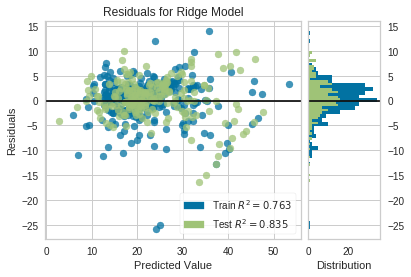

In [11]:
display_residual_plot(est, new_boston[:300, :], boston.target[:300], new_boston[300:, :], boston.target[300:])

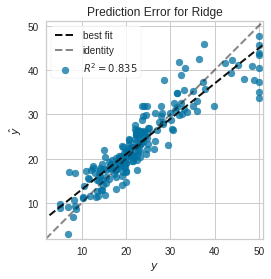

In [12]:
prediction_error_plot(est, new_boston[:300, :], boston.target[:300], new_boston[300:, :], boston.target[300:])

In [13]:
score_model(est, new_boston, boston.target)

Mean of metric: 4.271705130401322, std: 0.8609695211322863


In [14]:
est.score(new_boston[300:, :], boston.target[300:])

0.8351915615241654

In [15]:
score_test_data_for_model(est, new_boston[300:, :], boston.target[300:])

R2: 0.8351915615241654
RMSE: 3.94778571816425


## ATgfe

In [16]:
df = pd.DataFrame(data=boston.data, columns=boston.feature_names)
df['Y'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Y
0,0.06724,0.0,3.24,0.0,0.460,6.333,17.2,5.2146,4.0,430.0,16.9,375.21,7.34,22.6
1,9.23230,0.0,18.10,0.0,0.631,6.216,100.0,1.1691,24.0,666.0,20.2,366.15,9.53,50.0
2,0.11425,0.0,13.89,1.0,0.550,6.373,92.4,3.3633,5.0,276.0,16.4,393.74,10.50,23.0
3,24.80170,0.0,18.10,0.0,0.693,5.349,96.0,1.7028,24.0,666.0,20.2,396.90,19.77,8.3
4,0.05646,0.0,12.83,0.0,0.437,6.232,53.7,5.0141,5.0,398.0,18.7,386.40,12.34,21.2


In [17]:
X = df.drop('Y', axis=1).copy()
Y = df.loc[:, 'Y'].copy()
columns = X.columns.tolist()
X_train, X_test, y_train, y_test = X.iloc[:300, :], X.iloc[300:, :], Y.iloc[:300], Y.iloc[300:]

In [18]:
def create_new_model():
    return make_pipeline(StandardScaler(), LinearRegression(n_jobs=-1))

In [19]:
model = create_new_model()

In [20]:
score_model(model, X, Y)

Mean of metric: 4.796271960190554, std: 0.8909128895221894


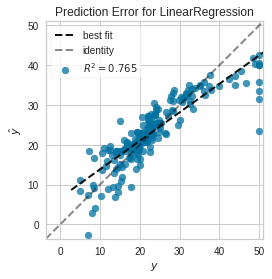

In [21]:
prediction_error_plot(model, X_train, y_train, X_test, y_test)

In [22]:
model.fit(X_train, y_train);

In [23]:
score_test_data_for_model(model, X_test, y_test)

R2: 0.7650083307199256
RMSE: 4.714005473450092


# Run ATgfe with operations

In [24]:
model = create_new_model()

In [25]:
gfe = GeneticFeatureEngineer(model, x_train=X_train, y_train=y_train, numerical_features=columns,
                             number_of_candidate_features=10,
                             number_of_interacting_features=4,
                             evaluation_metric=rmse, n_jobs=62,
                             cross_validation_in_objective_func=True, objective_func_cv=5)

2019-11-27 22:06:46,661:INFO: New Engineer created with the following parameters: 
2019-11-27 22:06:46,662:INFO: 
Model type: <class 'sklearn.pipeline.Pipeline'>
Numerical Features: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
Number of candidate features: 10
Number of interacting features: 4
Evaluation Metric: rmse
Minimize metric is True 


In [26]:
gfe.fit(mu=1000, lambda_=2000, early_stopping_patience=3, mutation_probability=0.4, crossover_probability=0.6)

Start of evolution
   	      	                                                    fitness                                                    
   	      	---------------------------------------------------------------------------------------------------------------
gen	nevals	avg     	best_val_score	gen	gen_val_score	max  	min    	nevals	std        	time_in_seconds
0  	1000  	7.32e+10	nan           	0  	nan          	1e+11	4.14044	1000  	4.42918e+10	nan            
1  	2000  	2e+09   	4.04081       	1  	4.04081      	1e+11	4.0617 	2000  	1.4e+10    	3.82165        
2  	2000  	4.27186 	3.99653       	2  	3.99653      	4.70719	3.99027	2000  	0.111426   	5.11168        
3  	2000  	4.10269 	3.91751       	3  	3.91751      	4.34924	3.89306	2000  	0.0812425  	5.09254        
4  	2000  	3.95125 	3.73965       	4  	3.73965      	4.14868	3.81725	2000  	0.067402   	4.97852        
5  	2000  	3.86337 	3.73965       	5  	3.84786      	4.05836	3.78184	2000  	0.0357051  	4.93195        
6  	2000  	3.

In [27]:
X_train = gfe.transform(X_train)
X_test = gfe.transform(X_test)
X = gfe.transform(X)

In [28]:
X_test.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,CRIM - RM*TAX,NOX*(CRIM - PTRATIO*RM),B - B/TAX - CHAS,AGE/DIS + TAX/LSTAT,AGE*(RM + TAX)/RAD,LSTAT*TAX,AGE,LSTAT*(-AGE*NOX + DIS),NOX,AGE*B - NOX/INDUS
300,0.05644,40.0,6.41,1.0,0.447,6.758,32.9,4.0776,4.0,254.0,...,-1716.47556,-53.141309,394.337402,80.023146,2144.734550,896.62,32.9,-37.519311,0.447,13057.940265
301,3.83684,0.0,18.10,0.0,0.770,6.251,91.1,2.2955,24.0,666.0,...,-4159.32916,-94.273687,350.123498,86.620804,2551.752754,9450.54,91.1,-962.812785,0.770,31944.172459
302,0.08387,0.0,12.83,0.0,0.437,5.874,36.6,4.5026,5.0,398.0,...,-2337.76813,-47.965089,395.064874,51.864901,2956.357680,3621.80,36.6,-104.573560,0.437,14495.761939
303,0.31827,0.0,9.90,0.0,0.544,5.914,83.2,3.9986,4.0,304.0,...,-1797.53773,-59.023636,389.414803,37.392116,6446.211200,5572.32,83.2,-756.336126,0.544,32506.185051
304,0.40202,0.0,9.90,0.0,0.544,6.382,67.2,3.5325,4.0,304.0,...,-1939.72598,-63.662568,393.909967,48.366984,5214.417600,3149.44,67.2,-342.131748,0.544,26558.057051


In [29]:
model = create_new_model()

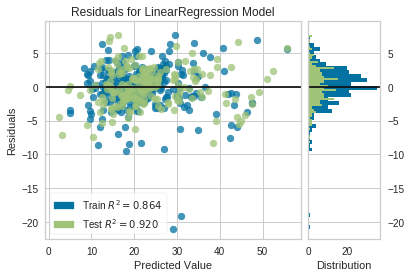

In [30]:
display_residual_plot(model, X_train, y_train, X_test, y_test)

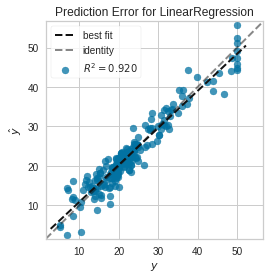

In [31]:
prediction_error_plot(model, X_train, y_train, X_test, y_test)

In [32]:
score_model(model, X, Y)

Mean of metric: 3.1250392598716186, std: 0.6767258696374376


In [33]:
model.fit(X_train, y_train);

In [34]:
score_test_data_for_model(model, X_test, y_test)

R2: 0.9195176011213487
RMSE: 2.7587624467675167


# LGBM

In [35]:
from lightgbm import LGBMRegressor

In [36]:
light_gbm_model = LGBMRegressor(n_estimators=500, random_state=7, reg_alpha=10)

In [37]:
X = df.drop('Y', axis=1).copy()
# X = gfe.transform(X)
Y = df.loc[:, 'Y'].copy()
columns = X.columns.tolist()
X_train, X_test, y_train, y_test = X.iloc[:300, :], X.iloc[300:, :], Y.iloc[:300], Y.iloc[300:]

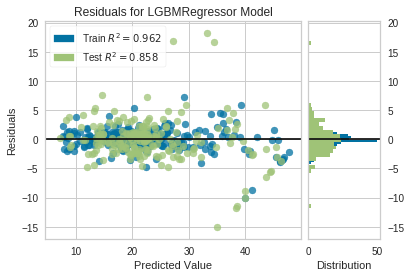

In [38]:
display_residual_plot(light_gbm_model, X_train, y_train, X_test, y_test)

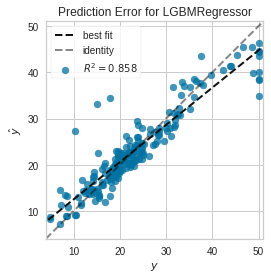

In [39]:
prediction_error_plot(light_gbm_model, X_train, y_train, X_test, y_test)

In [40]:
score_model(light_gbm_model, X, Y)

Mean of metric: 3.3792802897249943, std: 0.8444267782133263


In [44]:
light_gbm_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=7, reg_alpha=10, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [45]:
score_test_data_for_model(light_gbm_model, X_test, y_test)

R2: 0.8603393000500354
RMSE: 3.63413416405981
